# Анализ данных сервиса аренды самокатов GoFast

## Вводнные данные по проекту

### Цели и задачи проекта

Как аналитику сервиса аренды самокатов GoFast, необходимо проанализировать клиентскую базу и данные о поездках пользователей за определённый период.  

__ЦЕЛИ ИССЛЕДОВАНИЯ:__
1. Описать и визуализировать данные о пользователях сервиса.
2. Проверить несколько гипотез от продак-менеджеров относительно пользователей с подпиской и без.  

__ЗАДАЧИ:__
- определить, как много пользователей в каких городах
- сопоставить количество пользователей с подпиской и без
- представить возрастное распределение пользователей
- представить информацию о расстоянии, проезжаемом пользователями
- представить информацию о продолжительности поездок
- посчитать помесячную выручку каждого пользователя
- проверить гипотезы методами статистики

### Описание данных

Данные представлены 3 таблицами:  

__Таблица пользователей__ - `users_go.csv`
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

__Таблица поездок__ - `rides_go.csv`
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

__Таблица подписок__ - `subscriptions_go.csv`
- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

### План работы над проектом

1. Загрузить библиотеки и данные.
2. Проверить и предобработать данные.
3. Определить соотношение пользователей с подпиской и без.
4. Изучить для пользователей с подпиской и без: географию, возраст, расстояние и продолжительность поездок.
5. Определить, какая выручка от пользователей с подпиской и без.
6. Для каждого предположения от продакт-менеджеров сформулировать нулевые и альтернативные гипотезы и проверить их.

## Загрузка библиотек и данных

Загрузим нужные библиотеки и сделаем необходимые настроки.

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
import datetime
import calendar
import itertools
from datetime import datetime, timedelta
from collections import Counter
import scipy.stats as st
from scipy import stats




# настройки библиотек
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# сброс предупреждений
warnings.filterwarnings('ignore')
# настройка полного отображения в ячейках
pd.set_option('max_colwidth', -1)
# настройка размера шрифта для графиков
plt.rcParams.update({'font.size': 15})

Создадим функции для вывода информации о таблицах и загрузки данных.

In [2]:
# создание функции
def def_info(df, rc=1, d=1, i=1, c=1, s=1):
    
    # описание функции и фрагмент для вывода: print(def_info.__doc__)
    """
    Эта функция выводит информацию о датафрейме:
    - количество строк и столбцов (в том числе пустых)
    - информация о дубликатах
    - сводная информация (аналог info)
    - названия столбцов
    - пример(ы) строк(и) датафрейма (можно указать количество)
    
    Принимает на вход:
    - `df` - датафрейм
    - `rc` - определяет вывод информации о количестве строк и столбцов (1 или 0)
    - `d` - определяет вывод информации о дубликатах (1 или 0)
    - `i` - определяет вывод сводной информации (1 или 0)
    - `c` - определяет вывод информации о названиях столбцов (1 или 0)
    - `s` - определяет вывод примера строки (значения больше 0 выводят указанное количество строк)
    
    Если указать только датафрейм, будет выведено всё.

    """
    
# получение и вывод информации о количестве строк и столбцов
    if rc == 1:
        empty_rows = (df.isna().all(axis=1)).sum()
        empty_rows_per = (df.isna().all(axis=1)).mean()
        empty_cols = (df.isna().all(axis=0)).sum()
        empty_cols_per = (df.isna().all(axis=0)).mean()
        print(f"- количество строк: {df.shape[0]}, \
              полностью пустых - {empty_rows} ({empty_rows_per:.0%})")
        print(f"- количество столбцов: {df.shape[1]}, \
              полностью пустых - {empty_cols} ({empty_cols_per:.0%})")
    
# создание таблицы для вывода сводной информации (аналог info(),
# но с указанием количества и доли пропусков для каждого столбца)    
    if i == 1:
        data_info = df.notnull().sum().to_frame(name='данные')
        data_info['пропуски'] = df.isnull().sum()
        data_info['% пропусков'] = round((df.isnull().sum() / len(df)), 2)
        data_info['тип данных'] = df.dtypes

# вывод таблицы с цветовой индикацией количества данных и пропусков
        display(data_info.style
            .format({'% пропусков': '{:.0%}'})
            .set_caption('сводная информация')
            .bar(subset=['данные'], color='lightgreen')
            .applymap(lambda x: 'background-color: peachpuff' if x > 0 else '' if x == 0 else '',
                      subset=['пропуски'])
            .bar(subset=['% пропусков'], color='coral')
            .set_table_styles([{'selector': 'caption', 
                                'props': [('color', 'coral'), ('font-size', '14px')]
                               }])
           )

# получение и вывод информации о количестве полных дубликатов
    if d == 1:
        duplicates = df.duplicated()
        num_duplicates = duplicates.sum()
        if num_duplicates == 0:
            print('Полных дубликатов нет')
        else:
            print('\033[1m\033[38;5;209m\nдубликаты\033[0m')    
            print('Количество полных дубликатов:', num_duplicates)
            
# вывод названий столбцов
    if c == 1:
        print('\033[1m\033[38;5;209m\nстолбцы\033[0m')
        print(df.columns.tolist())
        
# вывод нескольких строк для примера (можно указать количество)
    if s > 0:
        print('\033[1m\033[38;5;209m\nпример строк(и)\033[0m')
        display(df.sample(s))

In [3]:
# создание функции
def def_load_data(df_name, file_name, file_type, path=None, name=None, sep=None, sheet_name=0, header=0):

    # описание функции и фрагмент для вывода: print(def_load_data.__doc__)
    """
    Эта функция загружает данные из файла (csv или excel) и преобразует их в датафрейм для работы.
    Затем выводит основную информацию по файлу с помощью функции def_info
    Принимает на вход:
    - `df_name` - название создаваемого датафрейма
    - `file_name` - название загружаемого файла
    - `file_type` - тип загружаемого файла
    - `path` - путь к файлу (если файл находится в другой директории)
    - `name` - название таблицы для читателя, поясняющее содержимое файла
    - `sep` - разделитель для csv файла
    - `sheet_name` - имя листа в excel файле
    - `header` - номер строки, которую нужно использовать в качестве заголовка таблицы
    Обязательными являются только первые 3 параметра, остальные используются при необходимости.

    """
    
    # вывод информации об источнике
    print(
        '\033[1m\033[38;5;209mИСТОЧНИК\n{} - {}\033[0m'.format(file_name, name))
    
    # загрузка из источника определённого типа в датафрейм       
    if file_type == 'xls' or file_type == 'xlsx':
        try:
            df = pd.read_excel(path, sheet_name=sheet_name, header=header)
        except:
            df = pd.read_excel(file_name, sheet_name=sheet_name, header=header)
    elif file_type == 'csv':
        try:
            df = pd.read_csv(path, sep=sep)
        except:
            df = pd.read_csv(file_name, sep=sep)
    else:
        print('Тип файла не распознан')
        return
    globals()[df_name] = df
        
    # вывод информации о созданном датафрейме с помощью функции
    def_info(df, i=1, s=1, d=1, c=1)

Загрузим все таблицы и определим, какая предобработка необходима.

In [4]:
# загрузка данных с помощью функции
def_load_data('df_users_go', 'users_go.csv', 'csv',
              path='/datasets/users_go.csv',
              name='пользователи')

ИСТОЧНИК
users_go.csv - пользователи
- количество строк: 1565,               полностью пустых - 0 (0%)
- количество столбцов: 5,               полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
user_id,1565,0,0%,int64
name,1565,0,0%,object
age,1565,0,0%,int64
city,1565,0,0%,object
subscription_type,1565,0,0%,object



дубликаты
Количество полных дубликатов: 31

столбцы
['user_id', 'name', 'age', 'city', 'subscription_type']

пример строк(и)


,user_id,name,age,city,subscription_type
989,990,Елена,23,Сочи,free


In [5]:
# загрузка данных с помощью функции
def_load_data('df_rides_go', 'rides_go.csv', 'csv',
              path='/datasets/rides_go.csv',
              name='поездки')

ИСТОЧНИК
rides_go.csv - поездки
- количество строк: 18068,               полностью пустых - 0 (0%)
- количество столбцов: 4,               полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
user_id,18068,0,0%,int64
distance,18068,0,0%,float64
duration,18068,0,0%,float64
date,18068,0,0%,object


Полных дубликатов нет

столбцы
['user_id', 'distance', 'duration', 'date']

пример строк(и)


,user_id,distance,duration,date
11403,1058,1983.893614,11.612979,2021-06-30


In [6]:
# загрузка данных с помощью функции
def_load_data('df_subscriptions_go', 'subscriptions_go.csv', 'csv',
              path='/datasets/subscriptions_go.csv',
              name='подписки')

ИСТОЧНИК
subscriptions_go.csv - подписки
- количество строк: 2,               полностью пустых - 0 (0%)
- количество столбцов: 4,               полностью пустых - 0 (0%)


,данные,пропуски,% пропусков,тип данных
subscription_type,2,0,0%,object
minute_price,2,0,0%,int64
start_ride_price,2,0,0%,int64
subscription_fee,2,0,0%,int64


Полных дубликатов нет

столбцы
['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']

пример строк(и)


,subscription_type,minute_price,start_ride_price,subscription_fee
1,ultra,6,0,199


<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
<br>1. Во всех исходных таблицах корректно названы столбцы.
<br>2. Тип данных нужно будет изменить только в таблице поездок (столбец `data`).
<br>3. Пропусков нет ни в одной таблице.
<br>4. Полные дубликаты есть в таблице пользователей - необходимо будет их удалить. Также можно будет проверить таблицы на неявные дубликаты.
    
</div>

## Предобработка данных

### Календарные данные

Приведём столбец с датой у нужному типу данных.

In [7]:
# изменение типа данных
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])

# проверка
print('Новый тип данных в столбце `date`:', df_rides_go['date'].dtype)

Новый тип данных в столбце `date`: datetime64[ns]


Добавим новый столбец с номером месяца.

In [8]:
# добавление нового столбца
df_rides_go['month_number'] = df_rides_go['date'].apply(lambda x: x.month)

# проверка
print('Пример строки с новыми столбцми:')
display(df_rides_go.sample())
print('Уникальные значения нового календарного столбца:',
      ', '.join(map(str, sorted(df_rides_go['month_number'].unique()))))

Пример строки с новыми столбцми:


,user_id,distance,duration,date,month_number
7516,772,2840.915265,23.363661,2021-11-09,11


Уникальные значения нового календарного столбца: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12


Посмотрим, какой диапазон дат представлен в датасете о поездках.

In [9]:
# определение нужных дат и вывод информации
print('Диапазон дат датасета:', 
      df_rides_go['date'].min().strftime('%d %B %Y'),
      '-', df_rides_go['date'].max().strftime('%d %B %Y'))

Диапазон дат датасета: 01 January 2021 - 30 December 2021


### Обработка дубликатов

В таблице с пользователями были выявлены полные дубликаты. Посмотрим на них.

In [10]:
# определение дубликатов
duplicates = df_users_go[df_users_go.duplicated(keep=False)]

# вывод случайного примера дубликата
sample_user = duplicates['user_id'].sample().item()
duplicates.query('user_id == @sample_user')

,user_id,name,age,city,subscription_type
135,136,Марсель,25,Тюмень,ultra
1548,136,Марсель,25,Тюмень,ultra


Удалим полные дубликаты.

In [11]:
# удаление дубликатов
df_users_go = df_users_go.drop_duplicates(keep='first')

Теперь проверим на неявные дубликаты. В столбце `user_id` каждое значение должно встречаться только 1 раз (дубликаты возможны только если у пользователя в исследуемом периоде было 2 варианта участия: с подпиской и без).

In [12]:
# проверка дубликатов в столбце `user_id`
duplicates_in_column = df_users_go['user_id'].duplicated()

if duplicates_in_column.any():
    print(f"В столбце {'user_id'} есть дубликаты.")
else:
    print(f"В столбце {'user_id'} нет дубликатов.")

В столбце user_id нет дубликатов.


Значит, данные корректы и можно сделать вывод, что у каждого пользователя в исследуемом периоде был только один вариант участия: или с подпиской, или без.

### Проверка корректности категориальных столбцов

Посмотрим, какие значения содержатся в категориальных столбцах.  
Во всех трёх таблицах категориальными являются 3 столбца: с названием города, с именем пользователя и с типом подписки.

In [13]:
# вывод значений столбца с городм
print('Уникальные значения городов в датасете:\n',
      sorted(df_users_go['city'].unique()))

Уникальные значения городов в датасете:
 ['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск', 'Ростов-на-Дону', 'Сочи', 'Тюмень']


Значения корректные, неявных дубликатов нет.  

Столбец с именем пользователя проверять не будем - каждый пользователь мог ввести абсолютно любое имя, имена могут повторяться, а для исследование важнее user_id, нежели имя.  

Посмотрим на значения в столбце с указанием тарифа во всех таблицах.

In [14]:
# вывод информации
print('Уникальные значения столбца с типом подписки:')
print('- таблица `df_users_go`', sorted(df_users_go['subscription_type'].unique()))
print('- таблица `df_subscriptions_go`', sorted(df_subscriptions_go['subscription_type'].unique()))

Уникальные значения столбца с типом подписки:
- таблица `df_users_go` ['free', 'ultra']
- таблица `df_subscriptions_go` ['free', 'ultra']


Здесь также корректные значения.

### Проверка корректности количественных столбцов

В количественных столбцах находятся данные о возрасте пользователей, расстоянии и длительности поездок, стоимости подписки, стоимости старта и поминутного тарифа.  
Посмотрим на значения в этих столбцах.

In [15]:
# вывод информации
print('Возраста пользователей:',
      ', '.join(map(str, sorted(df_users_go['age'].unique()))))

print(
    f"\nВозраст пользователей колеблется от {df_users_go['age'].min()} до {df_users_go['age'].max()} лет."
)

Возраста пользователей: 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43

Возраст пользователей колеблется от 12 до 43 лет.


Данные столбца корректны.  

Посмотрим на столбец с расстоянием поездки - определим минимальное и максимальное расстояние и выведем примеры нескольких значений.

In [16]:
# вывод информаци
print('Минимальное расстояние -',
      round(df_rides_go['distance'].min(), 2),
      'м.'
     )

print('Максимальное расстояние -',
      round(df_rides_go['distance'].max(), 2),
      'м.'
     )

print('\nПримеры значений:',
      ', '.join(map(str, df_rides_go['distance'].sample(5))),
      sep='\n'
     )

Минимальное расстояние - 0.86 м.
Максимальное расстояние - 7211.01 м.

Примеры значений:
3122.5021235839754, 2647.687744467543, 2843.706823963954, 3678.188623415148, 4529.016163182906


Довольно странное минимальное расстояние (меньше метра). Похоже на аномалию.  
Выведем строку с минимальным значением.

In [17]:
# вывод информации
df_rides_go.query('distance == distance.min()')

,user_id,distance,duration,date,month_number
11555,1069,0.855683,10.001902,2021-01-31,1


Проехать за 10 минут меньше метра невозможно.
Но пока оставим как есть и посмотрим на столбец со временем поездок: также определим минимальное и максимальное время и выведем примеры значений.

In [18]:
# вывод информаци
print('Минимальное время поездки -',
      round(df_rides_go['duration'].min(), 2),
      'мин.'
     )

print('Максимальное время поездки -',
      round(df_rides_go['duration'].max(), 2),
      'мин.'
     )

print('\nПримеры значений:',
      ', '.join(map(str, df_rides_go['duration'].sample(5))),
      sep='\n'
     )

Минимальное время поездки - 0.5 мин.
Максимальное время поездки - 40.82 мин.

Примеры значений:
24.53895963432275, 16.0464699076285, 30.03634627651701, 19.5690912028882, 31.087804197564967


Полминуты тоже выглядят странно для поездки на самокате.   
Выведем строки с этим значением.

In [19]:
# вывод информации
df_rides_go.query('duration == duration.min()')

,user_id,distance,duration,date,month_number
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Тут тоже какие-то нереальные значения (5-7 км за полминуты).  

Попробуем выявить все аномалии - там, где время и расстояние (и соответственно скорость поездки) выглядят странно.  
Для начала свяжем расстояние и время в новом столбце скорости поездки.

In [20]:
# создание столбца со скоростью движения (м/мин)
df_rides_go['speed'] = round(df_rides_go['distance'] / df_rides_go['duration'], 2)

Посмотрим, как распределяются значения скорости для всех поездок на графиках.  
Создадим функцию.

In [21]:
# создание функции
def def_hist_boxplot(df, column, title, x_title, y_title, bins=30):
    
    # описание функции и фрагмент для вывода: print(def_hist_boxplot.__doc__)
    """
    Эта функция создаёт сводную таблицу из датафрейма
    и выводит распределение количества пациентов по заданому параметру.
    
    Принимает на вход:
    - `df` - датафрейм
    - `column` - название столбца
    - `plot_title` - заголовок графика
    - `x_axis_title` - подпись оси x
    - `bins` (по умолчанию 30)
    
    """
    
    # создание поля для гистограммы
    fig, ax = plt.subplots(figsize=(20, 6))

    # построение гистограммы
    ax.hist(df[column], bins=bins, color='skyblue', edgecolor='black')

    # настройка заголовка и меток осей
    ax.set_title(title, color='red')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)

    # вывод гистограммы
    plt.show();
    
    # создание графика
    sns.set(rc={"figure.figsize":(20, 3)})
    sns.set_context("poster", font_scale=0.7, rc={"grid.linewidth": 1.8})
    
    # определение исходных данных
    sns.boxplot(x=df.query(f'{column} != 0')[column], color='coral')
    
    # установка подписей
    plt.title(title, color='red')
    plt.xlabel(x_title)
    
    # вывод графика и информации
    plt.show()
    print('СТАТИСТИКА', df.query(f'{column} != 0')[column].describe(), sep='\n\n')

Выведем графики по столбцу скорости.

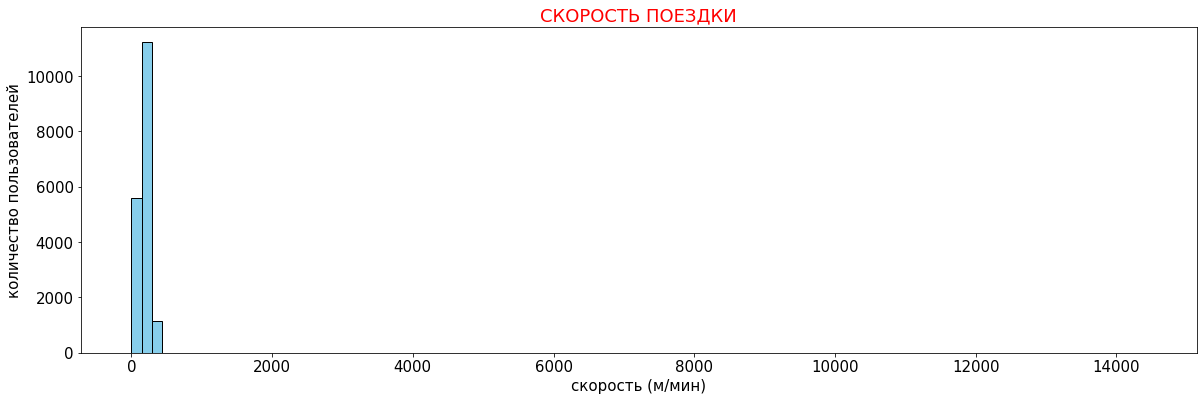

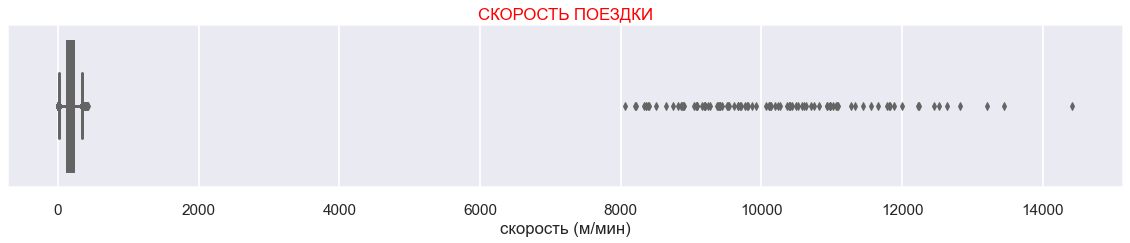

СТАТИСТИКА

count    18068.000000
mean     229.754386  
std      735.936466  
min      0.090000    
25%      135.462500  
50%      170.850000  
75%      215.495000  
max      14422.020000
Name: speed, dtype: float64


In [22]:
# вывод информации с помощью функции
def_hist_boxplot(
    df_rides_go, 'speed', 'СКОРОСТЬ ПОЕЗДКИ', 'скорость (м/мин)', 'количество пользователей',
    bins=100
)

На графиках видно, что есть много довольно далёких выбросов, отражающих скорость выше 8 км в минуту. Но больше аномальных значений около нуля.  

Выделим все аномальные значения в отдельную таблицу.  
Возьмём "странную" скорость для самоката (например, когда меньше метра едут за 10 минут или когда за полминуты преодолевают расстояние в 4-5 км. Будем считать, что максимальная скорость движения самоката - 30 км/ч (сейчас уже принят закон о максимальных 25 км/ч, но возьмём с запасом). В качестве минимальной возьмём 10 м/мин.

In [23]:
# определение порогов скорости в м/мин
lower_speed_threshold = 10 # Минимальная разумная скорость
upper_speed_threshold = 500  # Максимальная разумная скорость

# фильтр данных для поиска аномалий
df_speed_anomalies = df_rides_go.query('speed < @lower_speed_threshold | speed > @upper_speed_threshold')

# вывод количества аномальных значений
print('Количество аномальных значений:', len(df_speed_anomalies))

Количество аномальных значений: 154


Посмотрим примеры значений.

In [24]:
# вывод примера аномальной строки (можно запускать несколько раз, чтобы получать разные примеры)
# определение случайного значения аномальной скорости
speed_sample = df_speed_anomalies['speed'].sample().item()

# вывод информации
print('ПРИМЕР АНОМАЛЬНОГО ЗНАЧЕНИЯ:')
print('Пользователь проехал',
     round(df_speed_anomalies.query('speed == @speed_sample')['distance'].head().item(), 1), 'метров',
      'за', round(df_speed_anomalies.query('speed == @speed_sample')['duration'].head().item(), 1), 'минут',
      'со скоростью',
      round(df_speed_anomalies.query('speed == @speed_sample')['speed'].head().item()),'м/мин.'
     )

# вывод примера строки
display(df_speed_anomalies.query('speed == @speed_sample').head())

ПРИМЕР АНОМАЛЬНОГО ЗНАЧЕНИЯ:
Пользователь проехал 4848.5 метров за 0.5 минут со скоростью 9697 м/мин.


,user_id,distance,duration,date,month_number,speed
9049,890,4848.485014,0.5,2021-11-20,11,9696.97


И выведем на графиках только аномалии.

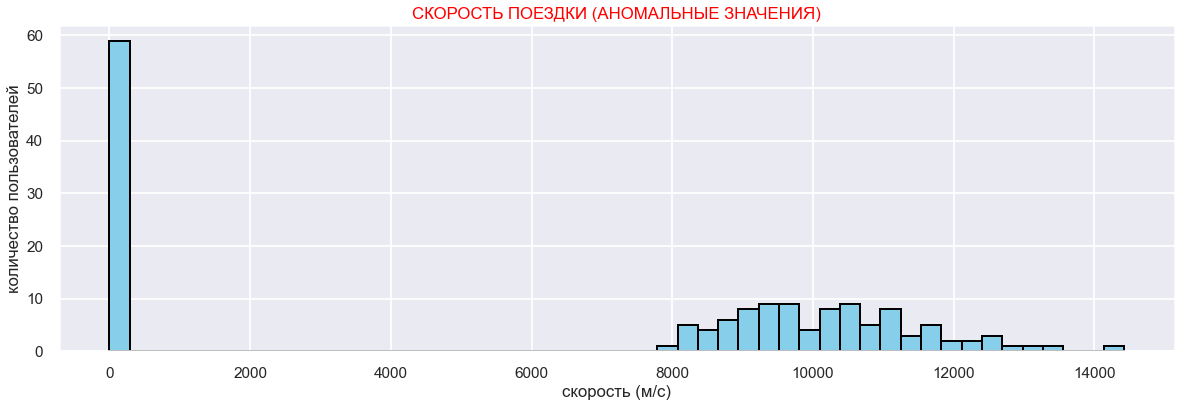

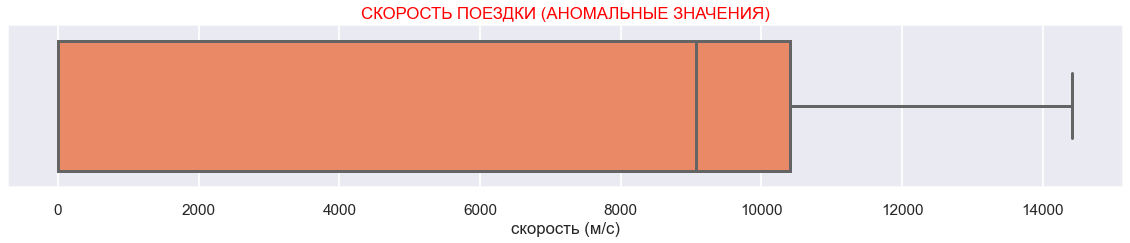

СТАТИСТИКА

count    154.000000  
mean     6310.696558 
std      5090.570162 
min      0.090000    
25%      7.455000    
50%      9073.055000 
75%      10405.500000
max      14422.020000
Name: speed, dtype: float64


In [25]:
# вывод информации с помощью функции
def_hist_boxplot(
    df_speed_anomalies, 'speed', 'СКОРОСТЬ ПОЕЗДКИ (АНОМАЛЬНЫЕ ЗНАЧЕНИЯ)', 'скорость (м/с)',
    'количество пользователей',
    bins=50
)

Данные графики также подтверждают предыдущий вывод.  
Необходимо будет показать аномальные значения техническому отделу (сохраним их в отдельный файл).   
Для текущего исследования аномалии удалим.

In [26]:
# сохранение результатов в новый файл
# df_speed_anomalies.to_csv('df_speed_anomalies.csv', index=False)

In [27]:
# удаление строк из датафрейма по индексам
df_rides_go = df_rides_go.drop(df_speed_anomalies.index)

Ещё раз выведем графики скорости.

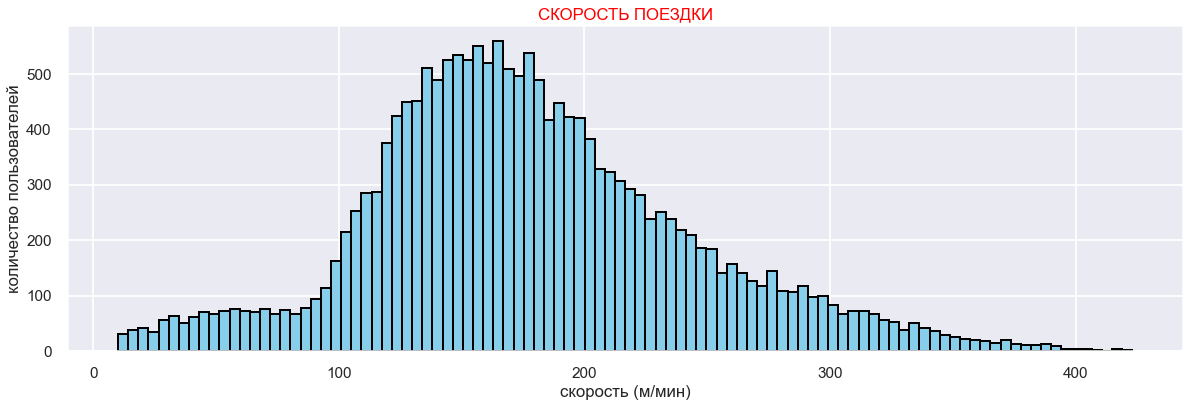

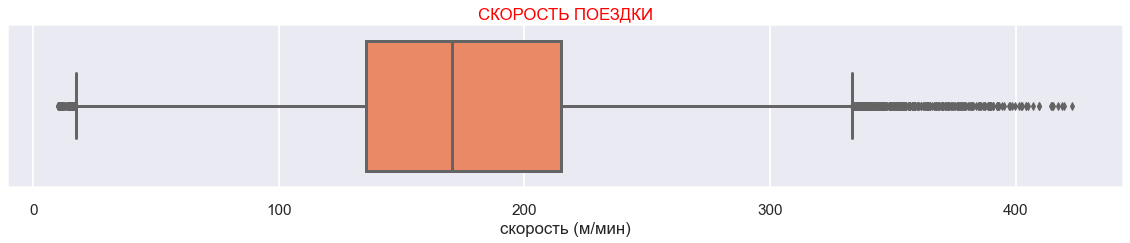

СТАТИСТИКА

count    17914.000000
mean     177.478786  
std      65.461224   
min      10.020000   
25%      135.675000  
50%      170.680000  
75%      214.730000  
max      423.170000  
Name: speed, dtype: float64


In [28]:
# вывод информации с помощью функции
def_hist_boxplot(
    df_rides_go, 'speed', 'СКОРОСТЬ ПОЕЗДКИ', 'скорость (м/мин)', 'количество пользователей',
    bins=100
)

Теперь они выглядят вполне адекватно. 

Дальше посиотрим на данные о стоимости поездки.

In [29]:
# вывод информаци
print('Стоимость подписки `ultra` в месяц:',
df_subscriptions_go.query('subscription_type != "free"')['subscription_fee'].item(),
      '₽.'
     )

print('\nСтоимость старта с подпиской:',
df_subscriptions_go.query('subscription_type != "free"')['start_ride_price'].item(),
      '₽.'
     )

print('Стоимость старта без подписки:',
df_subscriptions_go.query('subscription_type == "free"')['start_ride_price'].item(),
      '₽.'
     )

print('\nСтоимость минуты с подпиской:',
df_subscriptions_go.query('subscription_type != "free"')['minute_price'].item(),
      '₽.'
     )

print('Стоимость минуты без подписки:',
df_subscriptions_go.query('subscription_type == "free"')['minute_price'].item(),
      '₽.'
     )

Стоимость подписки `ultra` в месяц: 199 ₽.

Стоимость старта с подпиской: 0 ₽.
Стоимость старта без подписки: 50 ₽.

Стоимость минуты с подпиской: 6 ₽.
Стоимость минуты без подписки: 8 ₽.


Тут всё логично, данные выглядят корректными.

<div style="border:solid green 2px; padding: 20px">

<b>ВЫВОДЫ по разделу</b><br><br>
<br>1. В столбце с датой поездки изменён тип данных. Добавлен новый столбец с номером месяца.
<br>2. Удалены полные дубликаты, обнаруженные в таблице профилей клиентов, все таблицы проверены на неявные дубликаты.
<br>3. Категорияльные значения в датасетах корректны.
<br>4. Количественные значения в датасетах корректны (удалены аномальные значения времени и расстояния).
    
<br>Можно приступать к анализу.
    
</div>

## Исследовательский анализ данных

### Объединение данных

Для дальнейшей работы объединим данные о пользователях с данными о поездках и о стоимости тарифов.

In [30]:
# объединение исходных датафреймов в один общий
df_go = pd.merge(df_rides_go, df_users_go, on='user_id', how='inner')
df_go = pd.merge(df_go, df_subscriptions_go, on='subscription_type', how='inner')

Создадим ещё 2 датафрейма с пользователями с подпиской и с пользователями без подписки.

In [31]:
# вывод примера строки
df_go.sample()

,user_id,distance,duration,date,month_number,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
2106,225,3746.412034,22.985648,2021-07-08,7,162.99,Егор,25,Пятигорск,ultra,6,0,199


### Соотношение пользователей с подпиской и без подписки

Для дальнейшего исследование и ответов на вопросы продакт-менеджеров важно разделение пользователей на две группы: на тех, кто пользуется подпиской и тех, кто не пользуется. Поэтому для начала исследуюем именно этот параметр.

Мы знаем, что в исследуемом периоде у каждого пользователя был только один вариант участия: или с подпиской, или без.  
Посмотрим, как распределяются пользователи по этому параметру.

ПОЛЬЗОВАТЕЛИ С ПОДПИСКОЙ И БЕЗ


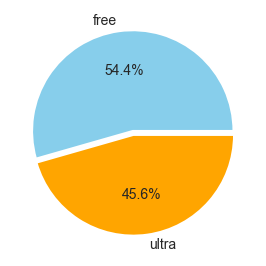

In [32]:
# группировка данных и подсчёт количества пользователей по типам подписки
users_by_subcribe = (
    df_go.groupby('subscription_type')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'users_count'})
)

# вывод заголовка
print('\033[1m\033[38;5;209mПОЛЬЗОВАТЕЛИ С ПОДПИСКОЙ И БЕЗ\033[0m')

# создание поля для диаграммы
fig, axis = plt.subplots()

# создание круговой диаграммы
users_by_subcribe['users_count'].plot(
    ax=axis,
    kind='pie',
    figsize=(4, 4),
    autopct='%1.1f%%',
    pctdistance=0.6,
    textprops={'fontsize': 14},
    explode=[0.02] * len(users_by_subcribe),
    colors=['skyblue', 'orange']
)

# отключение подписи оси y
axis.set_ylabel('')

# вывод диаграммы
plt.tight_layout()
plt.show()

Пользователей без подписки больше (54.4%), чем пользователей с подпиской (45.6%)

### География пользователей

Посмотрим, как распределились пользователи сервиса по городам.
Сначала выведем общее количество всех пользователей.

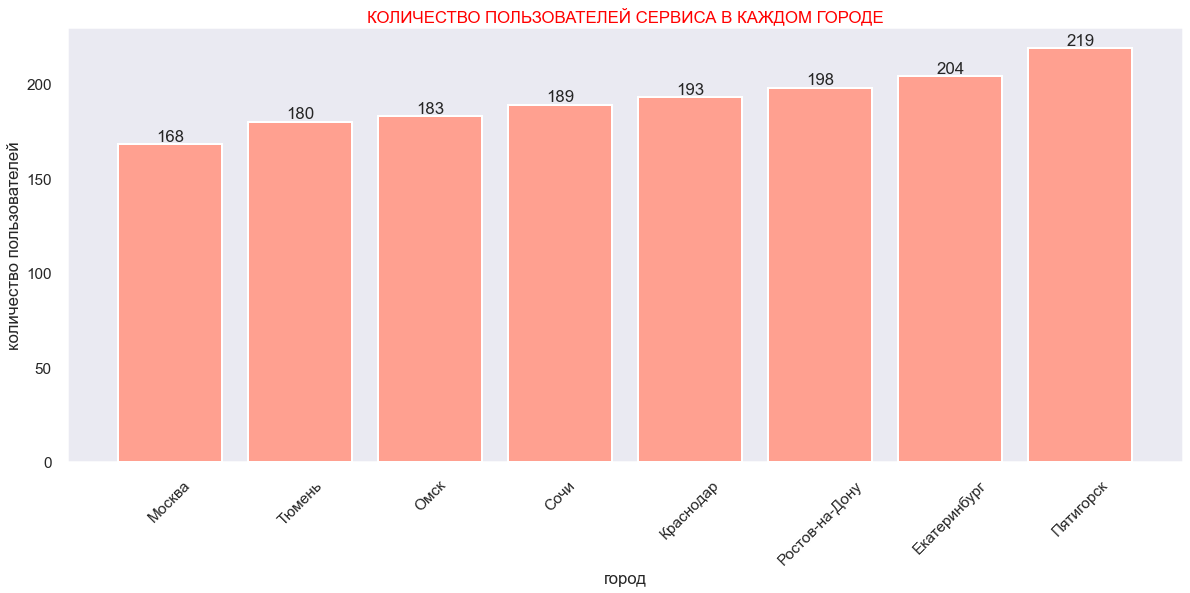

In [33]:
# группировка данных по городу и подсчет количества пользователей в каждом городе
city_users_count = df_users_go.groupby('city').size().sort_values()

# создание графика
plt.figure(figsize=(20, 8))
bars = plt.bar(city_users_count.index, city_users_count, color='#ffa090')
plt.title('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ СЕРВИСА В КАЖДОМ ГОРОДЕ', color='red')
plt.xlabel('город')
plt.ylabel('количество пользователей')
plt.xticks(rotation=45)

# добавление подписей внутри столбцов
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
    
# удаление сетки
plt.grid(False)

plt.show()

Больше всего пользователей в Пятигорске (219 человек) и меньше всего в Москве (168 человек).

Посмотрим, как пользователи с подпиской и без распределяются по городам.

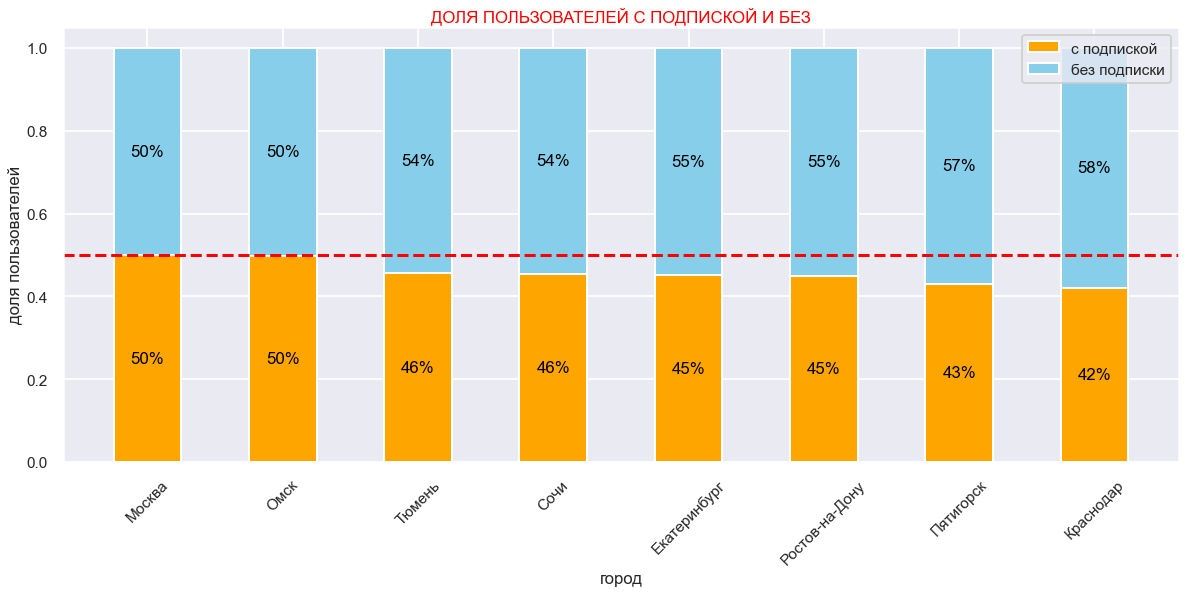

In [34]:
# группировка данных по городу и типу подписки, подсчет количества пользователей
city_subscription_count = (
    df_users_go.groupby(['city', 'subscription_type']).size().unstack())

# вычисление доли пользователей с подпиской и без подписки для каждого города
city_subscription_count['total'] = city_subscription_count.sum(axis=1)
city_subscription_count['subscription_rate'] = (
    city_subscription_count['ultra'] / city_subscription_count['total'])
city_subscription_count['non_subscription_rate'] = (
    city_subscription_count['free'] / city_subscription_count['total'])

# сортировка данных по доле пользователей с подпиской
city_subscription_count_sorted = (
    city_subscription_count.sort_values(by='subscription_rate', ascending=False))


# создание графика
plt.figure(figsize=(20, 8))
bar_width = 0.5  # Изменение ширины столбцов на 0.5
cities = city_subscription_count_sorted.index
subscription_bars = plt.bar(
    cities,
    city_subscription_count_sorted['subscription_rate'],
    width=bar_width, label='с подпиской', color='orange')

non_subscription_bars = plt.bar(
    cities,
    city_subscription_count_sorted['non_subscription_rate'],
    width=bar_width, bottom=city_subscription_count_sorted['subscription_rate'],
    label='без подписки', color='skyblue')

plt.title('ДОЛЯ ПОЛЬЗОВАТЕЛЕЙ С ПОДПИСКОЙ И БЕЗ', color='red')
plt.xlabel('город')
plt.ylabel('доля пользователей')
plt.legend()
plt.xticks(rotation=45)

# добавление линии 50%
plt.axhline(y=0.5, color='red', linestyle='--', label='50%')

# добавление подписей в процентах на каждом столбце
for i in range(len(cities)):
    plt.text(i, city_subscription_count_sorted['subscription_rate'][i] / 2, 
             f"{city_subscription_count_sorted['subscription_rate'][i]*100:.0f}%", 
             ha='center', va='center', color='black')

    plt.text(i, city_subscription_count_sorted['subscription_rate'][i] + 
             city_subscription_count_sorted['non_subscription_rate'][i] / 2, 
             f"{city_subscription_count_sorted['non_subscription_rate'][i]*100:.0f}%", 
             ha='center', va='center', color='black')

# вывод графика
plt.show()

Почти во всех городах больше пользователей без подписки (исключение - Москва и Омск, в которых равное количество пользователей с подпиской и без).

### Возраст пользователей

Построим график для визуализации распределения пользователей по возрасту.

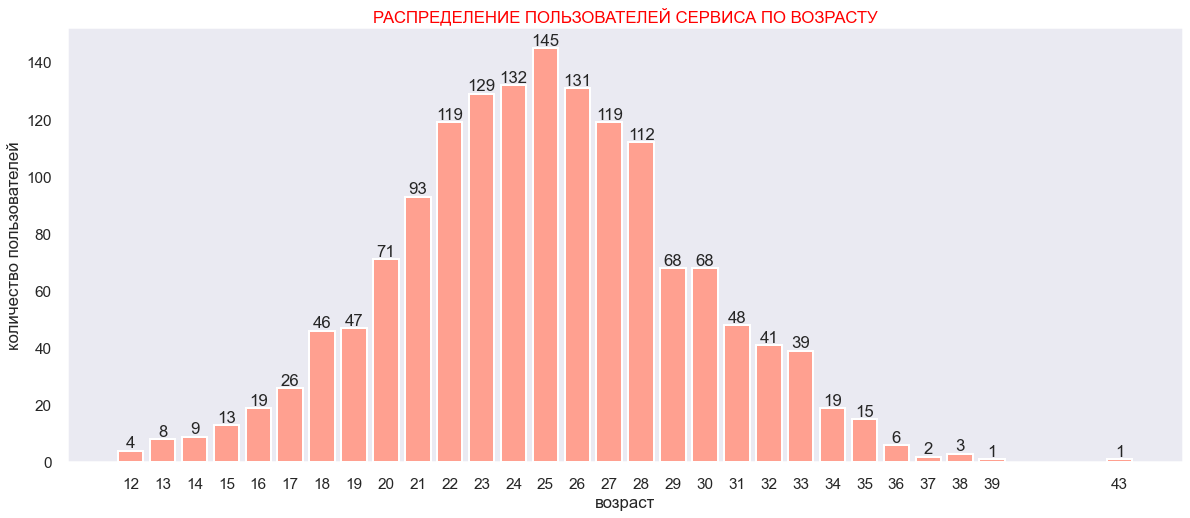

In [35]:
# группировка данных по возрасту и подсчет количества пользователей в каждой возрастной группе
age_users_count = df_users_go.groupby('age').size().sort_values()

# создание графика
plt.figure(figsize=(20, 8))
bars = plt.bar(age_users_count.index, age_users_count, color='#ffa090')
plt.title('РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ СЕРВИСА ПО ВОЗРАСТУ', color='red')
plt.xlabel('возраст')
plt.ylabel('количество пользователей')
plt.xticks()

# добавление подписей внутри столбцов
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# удаление сетки
plt.grid(False)

# добавление подписей к значениям на оси x
plt.xticks(age_users_count.index, labels=age_users_count.index)

plt.show()

На графике видно, что больше всего пользователей в возрасте 25 лет (145 человек)

Посмотрим на распределение возрастов для пользователей с подпиской и без.  
Создадим для этого функцию.

In [36]:
def def_compare_by_subscription_type(df, column, plot_title, x_axis_title):
    """
    Эта функция создаёт два скрипичных графика по пользователям с подпиской и без.
    
    Принимает на вход:
    - df - датафрейм
    - column - название столбца для распределение
    - plot_title - заголовок графика
    - x_axis_title - подпись оси x
    
    """
    
    # фильтрация данных по subscription_type
    free_type = df.query('subscription_type == "free"')[column]
    ultra_type = df.query('subscription_type != "free"')[column]

    # создание графика с двумя horizontal violinplot
    plt.figure(figsize=(20, 8))
    sns.violinplot(data=[free_type, ultra_type], palette=['skyblue', 'orange'], orient='h')
    
    # добавление вертикальной линии медианы для каждой скрипки
    for i, data in enumerate([free_type, ultra_type]):
        median_value = data.median()
        plt.axvline(median_value, color=['skyblue', 'orange'][i], linestyle='--')
        plt.text(median_value, i, f'{median_value:.2f}', color='black', va='bottom', ha='center', fontsize=35)
    
    plt.yticks([0, 1], ['free', 'ultra'])
    plt.title(plot_title, color='red')
    plt.ylabel('тип подписки')
    plt.xlabel(x_axis_title)
    plt.show()

И выведем распределение.

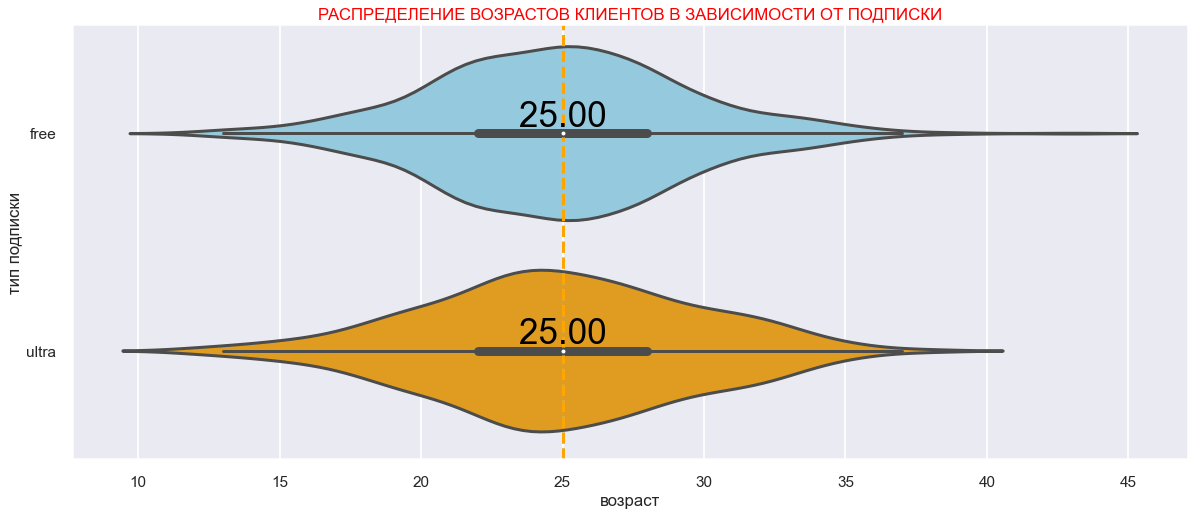

In [37]:
# вывод распределение с помощью функции
def_compare_by_subscription_type(df_users_go, 'age',
                                 'РАСПРЕДЕЛЕНИЕ ВОЗРАСТОВ КЛИЕНТОВ В ЗАВИСИМОСТИ ОТ ПОДПИСКИ',
                                'возраст')

Для обоих вариантов участия (с подпиской и без) характерно, что медианный возраст приходится на 25 лет.  
В целом, существенных отличий не наблюдается.

### Расстояние одной поездки пользователя

Для визуализации расспределения поездок по расстоянию воспользуемся созданной ранее функцией.

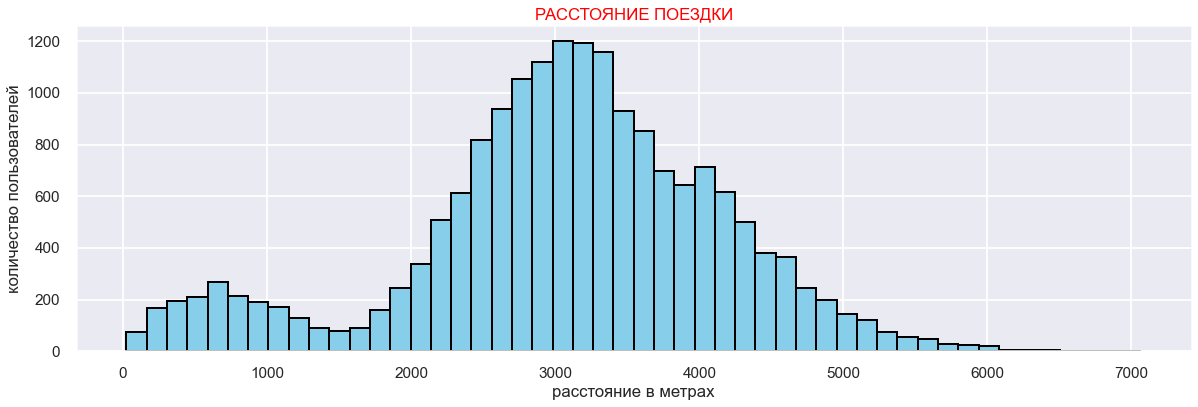

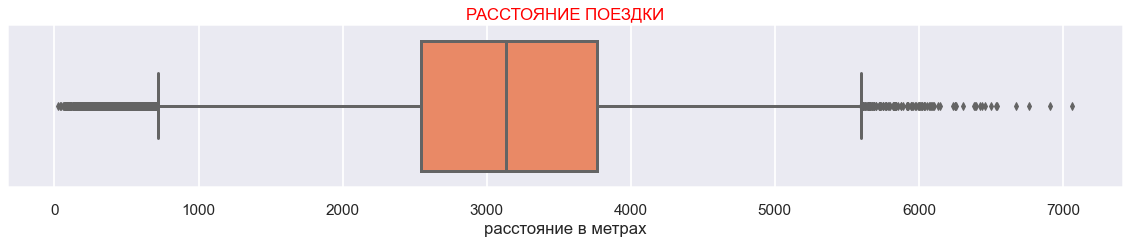

СТАТИСТИКА

count    17914.000000
mean     3069.759806 
std      1097.124335 
min      23.963062   
25%      2545.251904 
50%      3131.872649 
75%      3765.378318 
max      7066.003772 
Name: distance, dtype: float64


In [38]:
# вывод информации с помощью функции
def_hist_boxplot(
    df_go, 'distance', 'РАССТОЯНИЕ ПОЕЗДКИ', 'расстояние в метрах', 'количество пользователей',
    bins=50
)

Теперь посмотрим, как расстояние поездки расределяется между пользователями с подпиской и без.

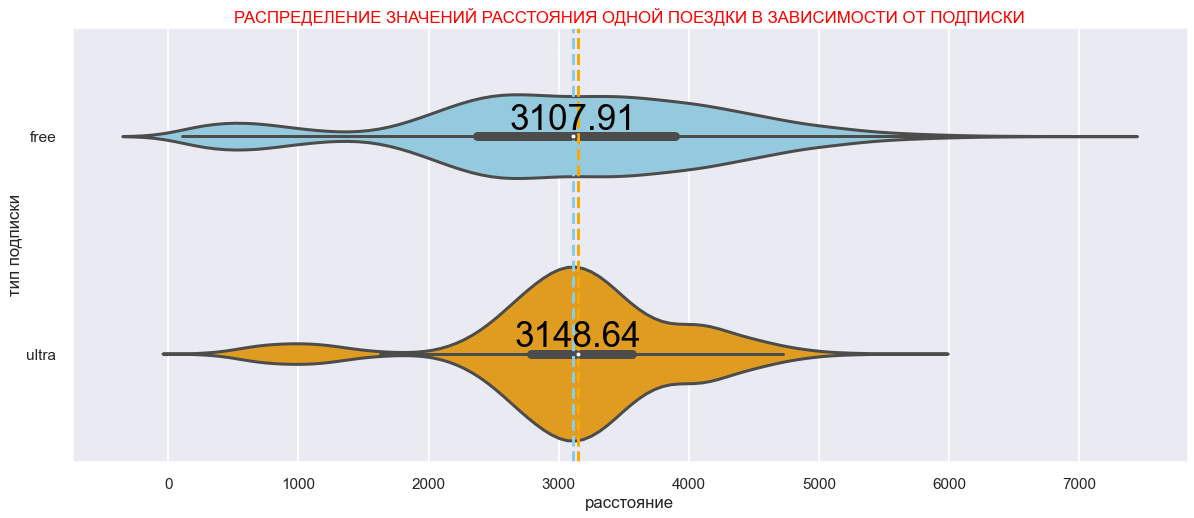

In [39]:
# вывод распределение с помощью функции
def_compare_by_subscription_type(
    df_go, 'distance', 'РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАССТОЯНИЯ ОДНОЙ ПОЕЗДКИ В ЗАВИСИМОСТИ ОТ ПОДПИСКИ',
    'расстояние')

У пользоввателей без подписки более равномерное распределение по проезжаемому расстоянию.   
Пользователи с подпиской проезжают немного больше.

### Продолжительность поездок

Визуализируем распределение по времени.

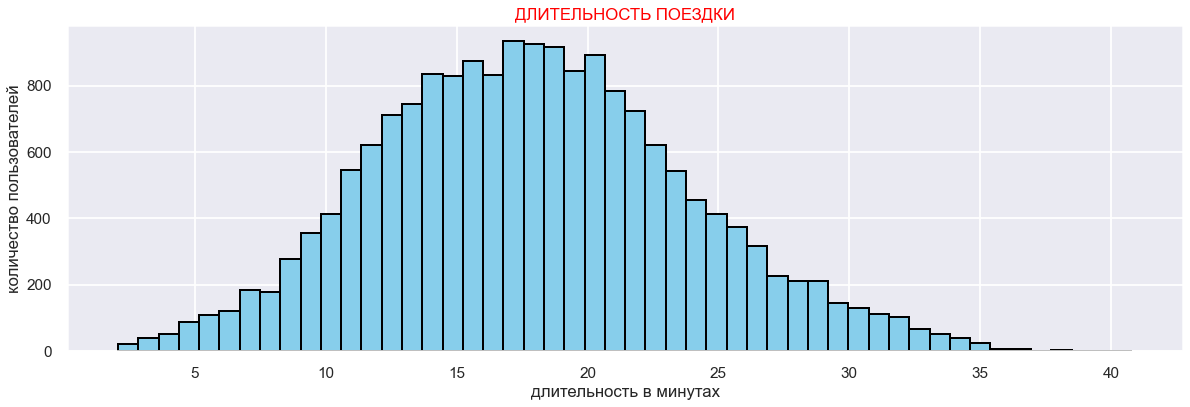

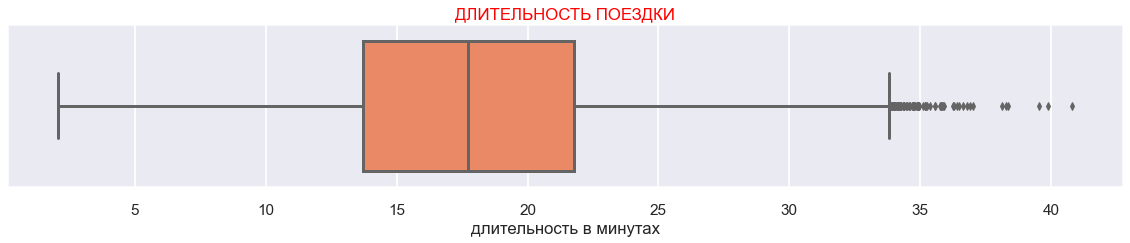

СТАТИСТИКА

count    17914.000000
mean     17.924379   
std      5.962242    
min      2.053251    
25%      13.714507   
50%      17.735224   
75%      21.758268   
max      40.823963   
Name: duration, dtype: float64


In [40]:
# вывод информации с помощью функции
def_hist_boxplot(
    df_go, 'duration', 'ДЛИТЕЛЬНОСТЬ ПОЕЗДКИ', 'длительность в минутах', 'количество пользователей',
    bins=50
)

Визуализируем информацию о расстоянии и длительности поездок для пользователей с подпиской.

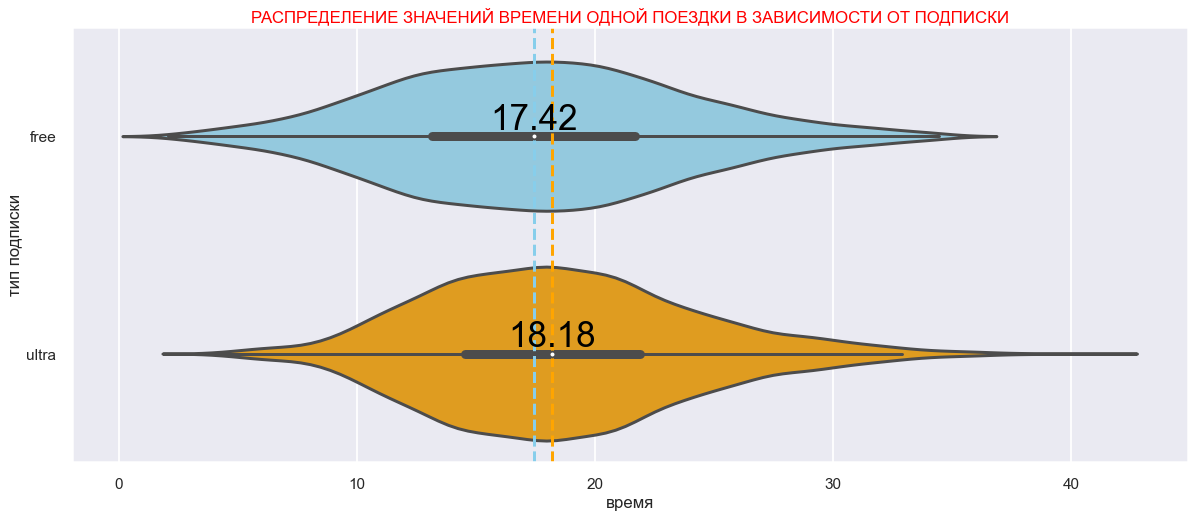

In [41]:
# вывод распределение с помощью функции
def_compare_by_subscription_type(
    df_go, 'duration', 'РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ ВРЕМЕНИ ОДНОЙ ПОЕЗДКИ В ЗАВИСИМОСТИ ОТ ПОДПИСКИ',
    'время')

Пользователи с подпиской в среднем ездят дольше (медиана, да и сама диаграмма пользователей с подпиской правее, чем у пользователей без). Но кажется, что незначительно.

## Подсчёт выручки

Для анализа помесячной выручки от каждого пользователя создадим сводную таблицу, содержащую суммарное расстояние, количество поездок и суммарное время.

In [42]:
# создание таблицы профилей пациентов
df_go_pivot = (
    df_go.groupby(['month_number', 'user_id', 'subscription_type'])
    .agg(
        rides_count=('date', 'count'),
        distance=('distance', 'sum'),
        duration=('duration', 'sum')
    )
    .reset_index()
)

# вывод примера строки
df_go_pivot.sample()

,month_number,user_id,subscription_type,rides_count,distance,duration
5081,6,666,ultra,1,2308.568766,16.695229


Округлим значение времени.

In [43]:
# округление
df_go_pivot['duration'] = np.ceil(df_go_pivot['duration']).astype(int)

In [44]:
# вывод примера строки
df_go_pivot.sample()

,month_number,user_id,subscription_type,rides_count,distance,duration
8625,10,218,ultra,2,3722.755361,32


Для добавления столбца зададим переменные, рассчитывающие выручку в зависимости от типа подписки.

In [45]:
# вывод примера строки
free_minute_price = (
    df_subscriptions_go.query('subscription_type == "free"')['minute_price'].item())
free_start_price = (
    df_subscriptions_go.query('subscription_type == "free"')['start_ride_price'].item())

ultra_minute_price = (
    df_subscriptions_go.query('subscription_type != "free"')['minute_price'].item())
ultra_subscription_price = (
    df_subscriptions_go.query('subscription_type != "free"')['subscription_fee'].item())

Добавим столбец с выручкой.

In [46]:
# создание нового столбца
def calculate_revenue(row):
    if row['subscription_type'] == 'free':
        return free_start_price * row['rides_count'] + free_minute_price * row['duration']
    elif row['subscription_type'] == 'ultra':
        return ultra_subscription_price + ultra_minute_price * row['duration']
    else:
        return None

df_go_pivot['revenue'] = df_go_pivot.apply(calculate_revenue, axis=1)

In [47]:
# вывод примера строки
df_go_pivot.sample()

,month_number,user_id,subscription_type,rides_count,distance,duration,revenue
3240,4,798,free,1,3414.329,23,234


Посмотрим на распределение выручки на графиках.

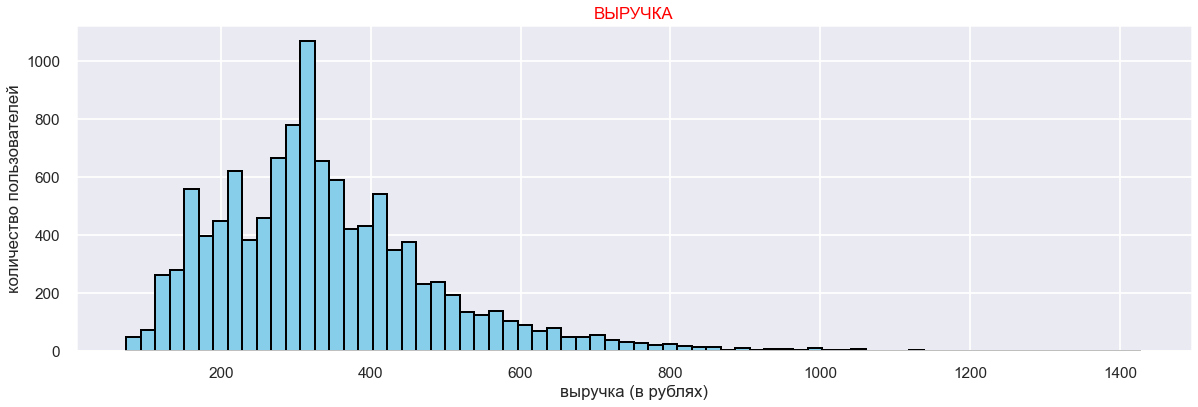

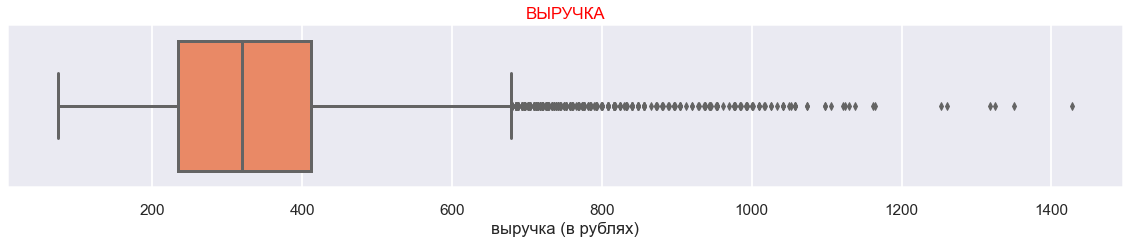

СТАТИСТИКА

count    11282.000000
mean     340.442563  
std      150.254466  
min      74.000000   
25%      234.000000  
50%      319.000000  
75%      412.000000  
max      1428.000000 
Name: revenue, dtype: float64


In [48]:
# вывод информации с помощью функции
def_hist_boxplot(
    df_go_pivot, 'revenue', 'ВЫРУЧКА', 'выручка (в рублях)', 'количество пользователей',
    bins=70
)

И выведем также распределение в зависимости от подписки.

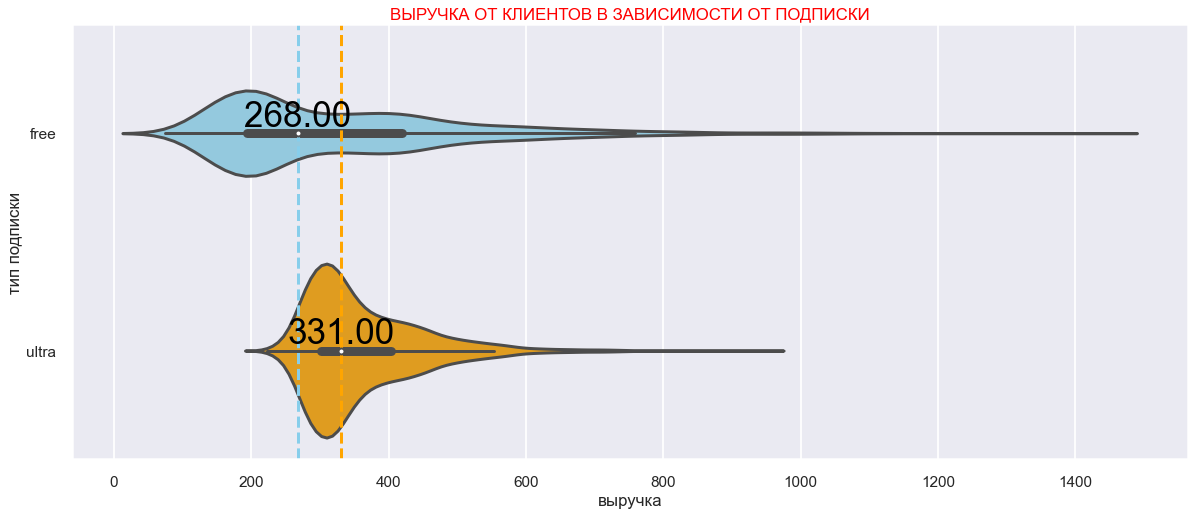

In [49]:
# вывод распределение с помощью функции
def_compare_by_subscription_type(
    df_go_pivot, 'revenue', 'ВЫРУЧКА ОТ КЛИЕНТОВ В ЗАВИСИМОСТИ ОТ ПОДПИСКИ',
    'выручка')

Помесячная выручка от одного пользователя с подпиской выше, чем помесячная выручка от одного пользователя без подписки.

Посмотрим в целом на общую выручку за год - какие пользователи приносят больше денег.

ДОХОД ОТ ПОЛЬЗОВАТЕЛЕЙ С ПОДПИСКОЙ И БЕЗ


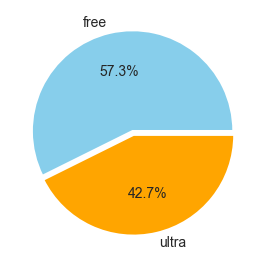

In [50]:
# группировка данных и подсчёт количества пользователей по типам подписки
revenue_by_subcribe = (
    df_go_pivot.groupby('subscription_type')
    .agg({'revenue': 'sum'})
)

# вывод заголовка
print('\033[1m\033[38;5;209mДОХОД ОТ ПОЛЬЗОВАТЕЛЕЙ С ПОДПИСКОЙ И БЕЗ\033[0m')

# создание поля для диаграммы
fig, axis = plt.subplots()

# создание круговой диаграммы
revenue_by_subcribe['revenue'].plot(
    ax=axis,
    kind='pie',
    figsize=(4, 4),
    autopct='%1.1f%%',
    pctdistance=0.6,
    textprops={'fontsize': 14},
    explode=[0.02] * len(users_by_subcribe),
    colors=['skyblue', 'orange']
)

# отключение подписи оси y
axis.set_ylabel('')

# вывод диаграммы
plt.tight_layout()
plt.show()

Большую часть дохода приносят пользователи без подписки (возможно за счёт того, что их больше)..

## Проверка гипотез

В рамках данного исследования необходимо проверить несколько гипотез.  Из каждого предположения продакт-менеджеров сформулируем нулевые и альтернативные гипотезы.

### Кто больше времени тратит на поездки?

__Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.__  

__Нулевая гипотеза:__
- средние значения времени поездки пользователей из двух групп равны  

__Альтернативные гипотезы:__
- среднее значение времени поездки пользователей с подпиской больше, чем среднее значение времени поездки пользователей без подписки
- среднее значение времени поездки пользователей с подпиской меньше, чем среднее значение времени поездки пользователей без подписки

In [51]:
# определение уровня значимости
alpha = 0.05

# траты первой группы пользователей (с подпиской)
first_group_total = df_go.query('subscription_type != "free"')['duration'].to_list()

# траты второй группы пользователей (без подпиской)
second_group_total = df_go.query('subscription_type == "free"')['duration'].to_list()

# ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results_greater = st.ttest_ind(first_group_total, second_group_total, alternative='greater')
# ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «меньше»
results_less = st.ttest_ind(first_group_total, second_group_total, alternative='less')
   
print(f'p-value (results_greater): {results_greater.pvalue}')
print(f'p-value (results_less): {results_less.pvalue}')
    
# проверка p-value и вывод результатов
if results_greater.pvalue < alpha:
    print('\nОтвергаем нулевую гипотезу - среднее время пользователей с подпиской выше.')
elif results_less.pvalue < alpha:
    print('\nОтвергаем нулевую гипотезу - среднее время пользователей с подпиской ниже.')
    
else:
    print('\nНет оснований отвергнуть нулевую гипотезу -',
          'среднее время поездки одинаково.')

p-value (results_greater): 5.44446383003763e-26
p-value (results_less): 1.0

Отвергаем нулевую гипотезу - среднее время пользователей с подпиской выше.


### Оптимально ли расстояние одной поездки?

__Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?__  

__Нулевая гипотеза:__
- расстояние, которое проезжают пользователи с подпиской равно 3130 метрам  

__Альтернативная гипотеза:__
- расстояние, которое проезжают пользователи с подпиской не равно 3130 метрам

In [52]:
# данные о расстоянии, которое проезжают пользователи с подпиской за одну поездку
distances = df_go.query('subscription_type != "free"')['distance'].to_list()

# оптимальное расстояние
optimal_distance = 3130

alpha = 0.05 # уровень статистической значимости


results = st.ttest_1samp(
    distances, 
    optimal_distance)

print('p-value:', results.pvalue)

# вывод результата
if results.pvalue < alpha:
    print("\nОтвергаем нулевую гипотезу: среднее расстояние превышает 3130 метров.")
else:
    print("\nНе отвергаем нулевую гипотезу: среднее расстояние не превышает 3130 метров.")

p-value: 0.16092623043004292

Не отвергаем нулевую гипотезу: среднее расстояние не превышает 3130 метров.


Определим среднее расстояние одной поездки для пользователей с подпиской.

In [53]:
# вывод информации
print('Среднее расстояние одной поездки пользователей с подпиской -',
      round(df_go.query('subscription_type != "free"')['distance'].mean()),
      'метров.'
     )

Среднее расстояние одной поездки пользователей с подпиской - 3115 метров.


### Кто приносит больше денег?

__Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.__  

__Нулевая гипотеза:__
- средние значения выручки от пользователей из двух групп равны   

__Альтернативные гипотезы:__
- среднее значение выручки от пользователей с подпиской больше, чем среднее значение выручки от пользователей без подписки
- среднее значение выручки от пользователей с подпиской меньше, чем среднее значение выручки от пользователей без подписки

In [54]:
# определяем уровень значимости
alpha = 0.05

# траты первой группы пользователей (с подпиской)
first_group_total = df_go_pivot.query('subscription_type != "free"')['revenue'].to_list()

# траты второй группы пользователей (без подпиской)
second_group_total = df_go_pivot.query('subscription_type == "free"')['revenue'].to_list()

# ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results_greater = st.ttest_ind(first_group_total, second_group_total, alternative='greater')
# ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «меньше»
results_less = st.ttest_ind(first_group_total, second_group_total, alternative='less')

print(f'p-value (results_greater): {results_greater.pvalue}')
print(f'p-value (results_less): {results_less.pvalue}')

# проверка p-value и вывод результатов
if results_greater.pvalue < alpha:
    print('\nОтвергаем нулевую гипотезу - среднее значение выручки от пользователей с подпиской больше.')
elif results_less.pvalue < alpha:
    print('\nОтвергаем нулевую гипотезу - среднее значение выручки от пользователей с подпиской меньше.')
    
else:
    print('\nНет оснований отвергнуть нулевую гипотезу -',
          'средние значения выручки от пользователей из двух групп равны')

p-value (results_greater): 1.0929888964025504e-34
p-value (results_less): 1.0

Отвергаем нулевую гипотезу - среднее значение выручки от пользователей с подпиской больше.


Выше мы уже выводили медианные значения, сейчас посмотрим на средние.

In [55]:
# вывод информации
print('Среднее значение помесячной выручки от пользователей с подпиской -',
      round(df_go_pivot.query('subscription_type != "free"')['revenue'].mean()),
      'рубль.'
     )

print('Среднее значение помесячной выручки от пользователей без подписки -',
      round(df_go_pivot.query('subscription_type == "free"')['revenue'].mean()),
      'рублей.'
     )

Среднее значение помесячной выручки от пользователей с подпиской - 361 рубль.
Среднее значение помесячной выручки от пользователей без подписки - 326 рублей.


 ### Обновление сервера

__Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось.  
Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.__

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel(), передав два параметра: наборы данных до и после.   

Будем действовать по такому плану:
- определим список пользователей, которые пользовались сервисов и до обновления, и после
- сделаем группировку по таким пользователям, рассчитав количество обращений до и после
- создадим 2 выборки значений
- проведём тест, используя метод scipy.stats.ttest_rel()

## Выводы и рекомендации

 <div style="border: solid green 4px; border-style: double; padding: 20px;">
    <b>ВЫВОДЫ ПО ПРОЕКТУ</b>
    
В рамках данного исследования была проанализированы данные о пользователях сервиса аренды самокатов GoFast и их поездках за период с 1 января по 30 декабря 2021 года.

<b>ПЕРЕРАБОТКА ИСХОДНЫХ ДАННЫХ</b><br>
Были изучены исходные таблицы, выявлены и удалены дубликаты. Были найдены аномальные значения времени и расстояния поездки - эти данные сохранены для технического отдела в отдельный csv-файл.
<br>Для исследования исходные данные были объединины в общий датафрейм.
    
<b>ИССЛЕДОВАНИЕ</b><br>
Определена доля клиентов с подпиской и без:
<br>- пользователей с подпиской - 45.6%;
<br>- пользователей без подписки - 54.4%.
    
<br>Были изучены профили клиентов (распределение по городам и возрастам):
<br>- лидирует по количеству клиентов Пятигорск (219 человек), на последнем месте - Москва (168 человек);
<br>- почти во всех городах больше клиентов без подписки (за исключением Москвы и Омска);
<br>- больше всего клиентов в возрасте от 22 до 28 лет.
    
<br>Визуализировано время и расстояние одной поездки как в целом, так и для пользователей с подпиской и без:
<br>- медианное расстояние одной поездки - 3132 метра;
<br>- у пользователей с подпиской медианное расстояние выше (3149 метров), чем у пользователей без подписки (3108 метров);
<br>- медианное расстояние одной поездки - 18 минут;
<br>- у пользователей с подпиской медианное время немного выше (18 минут), чем у пользователей без подписки (17 минут).    
    
<br>Составлена сводная табличка с помесячными данными по каждому пользователю: общим количеством поездок, суммарным временем и суммарным расстоянием. На основе этих данных и сведений о тарифах, определена выручка от каждого пользователя по месяцам. Выявлено, что 
<br>- медианная прибыль от одного клиента - 319 рублей;
<br>- от пользователей с подпиской медианная прибыль выше (331 рубль), чем от пользователей без подписки (268 рублей);
<br>- но в целом больше денег в 2021 году принесли пользователи без подписки (57.3%).

<b>ГИПОТЕЗЫ</b><br>
В результате проверки гипотез от продакт-менеджеров было определено:
<br><b>1. Пользователи с подпиской больше времени тратят на поездки.
<br><b>2. Пользователи с подпиской в среднем проезжают оптимальное расстояние с точки зрения износа самоката (3115 метров).
<br><b>3. Среднее значение помесячной выручки от пользователей с подпиской выше (361 рубль), чем от пользователей без подписки (326 рублей).
<br><b>Для проверки гипотезы от технической команды составлен алгоритм действий (при наличии нужных данных можно будет проверить, изменилось ли количество обращений в тех.поддержку после обновления серверов).
    
<b>ПОТЕНЦИАЛ ИССЛЕДОВАНИЯ</b>
<br>Текущий набор данных можно исследовать ещё глубже. Например, можно изучить влияет ли город проживания пользователя и его возраст на расстояние и время поездок. Можно посмотреть, меняется ли поведение пользователей со временем (сравнив первые и последующие поездки). Можно также проверить, была ли какая-нибудь закономерность у аномальных значений (с календарём, пользователем, городом).
    
</div>